In [ ]:
!pip install tensorflow==2.9

In [1]:
!pip install pyyaml

In [ ]:
!pip install plotly
!pip install seaborn

In [ ]:
!pip install h5py

In [3]:
import pandas as pd
import h5py
import plotly
#import pyyaml
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import os
import numpy as np
import timeit
import time
import tensorflow as tf
import tensorflow.keras
import pickle as pkl
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Attention
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
#import tensorflow_probability as tfp
#from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
#tf.compat.v1.disable_eager_execution()
np.set_printoptions(suppress=True)

In [4]:
print(tf.__version__)

2.9.0


In [5]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1050 (UUID: GPU-1b218410-060e-09cf-ec81-9b128fe198d4)


In [6]:
# Run script for processing events metadata #

%run metadata_proc.py

In [7]:
# Read and load metadata #

p = 'C:/Users/subed/Desktop/Research/Project_freq_domain/Codes/Stanford_Dataset'
data1 = p + '/ch2/chunk2.csv'
wave1 = p + '/ch2/chunk2.hdf5'
data2 = p + '/ch3/chunk3.csv'
wave2 = p + '/ch3/chunk3.hdf5'
data3 = p + '/ch5/chunk5.csv'
wave3 = p + '/ch5/chunk5.hdf5'
data4 = p + '/ch6/chunk6.csv'
wave4 = p + '/ch6/chunk6.hdf5'

d1, len1 = mda_proc(data1)
d2, len2 = mda_proc(data2)
d3, len3 = mda_proc(data3)
d4, len4 = mda_proc(data4)

print(d1.columns)

C:\Users\subed\AppData\Local\Temp/ipykernel_18648/2312846333.py:13: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  d1, len1 = mda_proc(data1)
C:\Users\subed\AppData\Local\Temp/ipykernel_18648/2312846333.py:14: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  d2, len2 = mda_proc(data2)
C:\Users\subed\AppData\Local\Temp/ipykernel_18648/2312846333.py:15: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  d3, len3 = mda_proc(data3)
C:\Users\subed\AppData\Local\Temp/ipykernel_18648/2312846333.py:16: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  d4, len4 = mda_proc(data4)


Index(['network_code', 'receiver_code', 'receiver_type', 'receiver_latitude',
       'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample',
       'p_status', 'p_weight', 'p_travel_sec', 's_arrival_sample', 's_status',
       's_weight', 'source_id', 'source_origin_time',
       'source_origin_uncertainty_sec', 'source_latitude', 'source_longitude',
       'source_error_sec', 'source_gap_deg',
       'source_horizontal_uncertainty_km', 'source_depth_km',
       'source_depth_uncertainty_km', 'source_magnitude',
       'source_magnitude_type', 'source_magnitude_author',
       'source_mechanism_strike_dip_rake', 'source_distance_deg',
       'source_distance_km', 'back_azimuth_deg', 'snr_db', 'coda_end_sample',
       'trace_start_time', 'trace_category', 'trace_name'],
      dtype='object')


In [8]:
# Merge pandas columns

m1 = d1[['source_magnitude']].to_numpy()
m2 = d2[['source_magnitude']].to_numpy()
m3 = d3[['source_magnitude']].to_numpy()
m4 = d4[['source_magnitude']].to_numpy()

mag = np.concatenate((m1,m2,m3,m4))

dp1 = d1[['source_depth_km']].to_numpy()
dp2 = d2[['source_depth_km']].to_numpy()
dp3 = d3[['source_depth_km']].to_numpy()
dp4 = d4[['source_depth_km']].to_numpy()

depth = np.concatenate((dp1,dp2,dp3,dp4))

az1 = d1[['back_azimuth_deg']].to_numpy()
az2 = d2[['back_azimuth_deg']].to_numpy()
az3 = d3[['back_azimuth_deg']].to_numpy()
az4 = d4[['back_azimuth_deg']].to_numpy()

azimuth = np.concatenate((az1,az2,az3,az4))

sn1 = d1[['snr_db']].to_numpy()
sn2 = d2[['snr_db']].to_numpy()
sn3 = d3[['snr_db']].to_numpy()
sn4 = d4[['snr_db']].to_numpy()

snratio = np.concatenate((sn1,sn2,sn3,sn4)) 

In [9]:
%run plots.py

In [ ]:
# Plot some metadata --> source_magnitude, source_depth_km, back_azimuth_deg, snr_db

mag_plot(mag)

In [ ]:
snr_plot(snratio)

In [ ]:
azimuth_plot(azimuth)

In [ ]:
depth_float = depth.astype(np.float)
print(depth[0:5])
print(depth_float[0:5])

In [ ]:
depth_int = depth_float.astype(int)

In [ ]:
np.histogram(depth_float)

In [10]:
def wave_proc(dt, w):
    ev = dt['trace_name'].to_list()
    x = np.zeros((len(dt),6000,3),np.float32)
    y = np.zeros((len(dt),1),np.float32)

    dtf = h5py.File(w,'r')

    for c, evi in enumerate(ev):
        eg = dtf.get('data/'+str(evi))
        data = np.array(eg)
        mag = round(float(eg.attrs['source_magnitude']),2)    
        psamp = int(eg.attrs['p_arrival_sample'])
        ssamp = int(eg.attrs['s_arrival_sample'])
        BAZ = round(float(eg.attrs['back_azimuth_deg']), 2)
        dpt = eg.attrs['source_depth_km']
        dis = round(float(eg.attrs['source_distance_deg']), 2)
        SNR = eg.attrs['snr_db']
    #dshort = data[psamp-100:psamp+2900,:]
        x[c,:,:] = data
        y[c,0] = mag
    
    dtf.close()
    return x, y, x.shape, y.shape


In [11]:
# Get waveforms of respective sets

w1, m1, wlen, mlen = wave_proc(d1,wave1)
w2, m2, wlen2, mlen2 = wave_proc(d2,wave2)
w3, m3, wlen3, mlen3 = wave_proc(d3,wave3)
w4, m4, wlen4, mlen4 = wave_proc(d4,wave4)

print(wlen, mlen)

(416, 6000, 3) (416, 1)


In [12]:
# Merge data

amp_merged = np.concatenate((w1,w2,w3,w4),axis=0) 
mag_merged = np.concatenate((m1,m2,m3,m4),axis=0)

print(amp_merged.shape,mag_merged.shape)

(2698, 6000, 3) (2698, 1)


In [13]:
# Runs script for visualising traces
%run trace_viz.py

In [ ]:
# Time domain plots #

tplot(amp_merged[5,:,:])

In [15]:
# Scripts for applying Hanning taper and FFT
%run hann_taper.py
%run sigproc.py

In [16]:
# Applies taper and FFT to signals

new_amp = np.zeros((len(amp_merged),6000,3),np.float32)
#tap_body = np.zeros((len(df2),6000,3),np.float32)
#tap_moment = np.zeros((len(df3),6000,3),np.float32)
for i in range(len(amp_merged)):
    x1 = myHanningTaper(amp_merged[i,:,0],0.1)
    x2 = myHanningTaper(amp_merged[i,:,1],0.1)
    x3 = myHanningTaper(amp_merged[i,:,2],0.1)
    #g = np.hstack((x1,x2,x3))
    #g = g.reshape(1,3000,3)
    new_amp[i,:,0] = x1
    new_amp[i,:,1] = x2
    new_amp[i,:,2] = x3
#ht = myHanningTaper(amp_merged)
fq = fconv(new_amp, len(new_amp))

print(fq.shape)

(2698, 3001, 3)


In [ ]:
# Frequency domain plots #

fplot(fq[5,:,:])

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [18]:
# Runs script containing Tensorflow model layers as classes
%run layers_class.py

In [19]:
# Train Test Split #

from sklearn.model_selection import train_test_split

x1 = fq[:,:,0]
x2 = fq[:,:,1]
x3 = fq[:,:,2]

train_e, test_e, ytrain_e, ytest_e = train_test_split(x1, mag_merged, shuffle=True, test_size=0.1)
train_n, test_n, ytrain_n, ytest_n = train_test_split(x2, mag_merged, shuffle=True, test_size=0.1)
train_z, test_z, ytrain_z, ytest_z = train_test_split(x3, mag_merged, shuffle=True, test_size=0.1)


train_e = np.reshape(train_e, (len(train_e),3001,1))
test_e = np.reshape(test_e, (len(test_e),3001,1))
train_n = np.reshape(train_n, (len(train_n),3001,1))
test_n = np.reshape(test_n, (len(test_n),3001,1))
train_z = np.reshape(train_z, (len(train_z),3001,1))
test_z = np.reshape(test_z, (len(test_z),3001,1))

print(train_e.shape, ytrain_e.shape, test_e.shape, ytest_e.shape)
print(train_n.shape, ytrain_n.shape, test_n.shape, ytest_n.shape)
print(train_z.shape, ytrain_z.shape, test_z.shape, ytest_z.shape)

(2428, 3001, 1) (2428, 1) (270, 3001, 1) (270, 1)
(2428, 3001, 1) (2428, 1) (270, 3001, 1) (270, 1)
(2428, 3001, 1) (2428, 1) (270, 3001, 1) (270, 1)


# Training channel E

In [20]:
# Training the first channel: E
epochs_number = 100
bach_size = 10
drop_rate = 0.2

#strategy = tf.distribute.MirroredStrategy()

#with strategy.scope():

inp = Input(shape=(3001,1), dtype='float32', name='input_layer')     # Input layer
#inp = tf.cast(inp, tf.int32)
# Embed frequency data #
#freq_embed = F2V(750,3001)(inp)
#freq_embed = tf.cast(freq_embed, tf.float32)
#print(K.get_value(e[:50]))
#encoder = Bidirectional(LSTM(50, return_sequences=True, dropout=0.0, recurrent_dropout=0.0))(inp)    # Bi-LSTM layer
#print(tf.shape(e))
#e = tf.reshape(e,(1500,200))
e1, awts, attn_out = attention1()(inp)                  # Bahdanau attention layer
#awts = awts.numpy()
#print(type(a))
#attn_out = tf.reshape(attn_out,(1500,200))
#e = tf.expand_dims(attn_out,axis=2)
print(tf.shape(awts))
print(tf.shape(attn_out))

#c1 = Conv1D(1,30,padding='same')(attn_out)
m1 = MaxPooling1D(30,padding='same')(attn_out)
#c2 = Conv1D(1,10,padding='same')(m1)
m2 = MaxPooling1D(10,padding='same')(m1)

e = Bidirectional(LSTM(70, return_sequences=False,dropout=0.0,recurrent_dropout=0.0))(m2)

d = Dense(1)(e)                                     # Fully connected layer
o = Activation('linear', name='output_layer')(d)           # Activation layer

model_e = Model(inputs=[inp], outputs=o)

model_e.compile(optimizer='Adam', loss='MSE')

lr_reducer = ReduceLROnPlateau(monitor='val_loss',         # Reduces learning rate while training
                               factor=np.sqrt(0.1),
                                patience= 4,
                               min_lr=0.5e-10
                              )
model_e.summary()

KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, 3001, 1], name='tf.compat.v1.shape/Shape:0', description="created by layer 'tf.compat.v1.shape'")
KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, 3001, 1], name='tf.compat.v1.shape_1/Shape:0', description="created by layer 'tf.compat.v1.shape_1'")
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 3001, 1)]         0         
                                                                 
 attention1 (attention1)     ((None, 3001, 1),         3002      
                              (None, 3001, 1),                   
                              (None, 3001, 1))                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 101, 1)           0         
 

In [ ]:
!pip install pydot
!pip install graphviz

In [21]:
import pydot
import graphviz

In [ ]:
# Plots and saves the model
tf.keras.utils.plot_model(model_e,show_shapes=True,to_file='freq_mag.png')

In [22]:
# Training
start = time.perf_counter()
history = model_e.fit(train_e, ytrain_e, epochs=epochs_number, validation_split=0.1, batch_size=bach_size, callbacks = [lr_reducer])
elap = time.perf_counter() - start
print('%.3f' % elap)

# Get attention scores
#enc = model.layers[1]
attention_layer = model_e.layers[1]
#encout = enc(train_e[0:1,:])
e2, awts, _ = attention_layer(train_e[0:1,:])
#print(tf.reduce_max(awts),tf.reduce_min(awts))
awts = tf.reshape(e2,(3001,1))
train1 = tf.reshape(train_e[0:1],(3001,1))
#print(tf.shape(awts))
#v = yz[:1]
#v = tf.reshape(v,(3001,1))
#av = tf.concat((awts,train1),axis=1)
#print(tf.shape(av))
#merged = tf.stack((awts,train1),axis=1)
#print(tf.shape(merged))
#fig, ax = plt.subplots(figsize=(10,10))
#fig, ax = plt.subplots(ncols=2, gridspec_kw=dict(width_ratios=[5,0.5]))
#title = 'Attention Heatmap'
#plt.title(title,fontsize=15)
#plt.setp(ax.get_xticklabels(), visible=False)
#ttl = ax.title
#ax.axis('off')
#ttl.set_position([0.5,1.05])
#sns.heatmap(awts[:,:])#, annot=True, cbar=True)#, ax=axs[1])
#fig.colorbar(axs[1].collections[0], cax=axs[1])
#plt.show()

Epoch 1/100
219/219 [==============================] - 8s 9ms/step - loss: 1.6941 - val_loss: 0.4501 - lr: 0.0010
Epoch 2/100
219/219 [==============================] - 1s 5ms/step - loss: 0.3754 - val_loss: 0.4016 - lr: 0.0010
Epoch 3/100
219/219 [==============================] - 1s 5ms/step - loss: 0.3535 - val_loss: 0.4274 - lr: 0.0010
Epoch 4/100
219/219 [==============================] - 1s 5ms/step - loss: 0.3690 - val_loss: 0.3443 - lr: 0.0010
Epoch 5/100
219/219 [==============================] - 1s 5ms/step - loss: 0.3637 - val_loss: 0.3547 - lr: 0.0010
Epoch 6/100
219/219 [==============================] - 1s 5ms/step - loss: 0.3375 - val_loss: 0.3483 - lr: 0.0010
Epoch 7/100
219/219 [==============================] - 1s 5ms/step - loss: 0.3418 - val_loss: 0.3557 - lr: 0.0010
Epoch 8/100
219/219 [==============================] - 1s 5ms/step - loss: 0.3263 - val_loss: 0.4007 - lr: 0.0010
Epoch 9/100
219/219 [==============================] - 1s 5ms/step - loss: 0.3065 - val_

219/219 [==============================] - 1s 5ms/step - loss: 0.2344 - val_loss: 0.2741 - lr: 1.0000e-07
Epoch 71/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2344 - val_loss: 0.2741 - lr: 1.0000e-07
Epoch 72/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2344 - val_loss: 0.2741 - lr: 1.0000e-07
Epoch 73/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2344 - val_loss: 0.2741 - lr: 1.0000e-07
Epoch 74/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2343 - val_loss: 0.2741 - lr: 3.1623e-08
Epoch 75/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2343 - val_loss: 0.2741 - lr: 3.1623e-08
Epoch 76/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2343 - val_loss: 0.2741 - lr: 3.1623e-08
Epoch 77/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2343 - val_loss: 0.2741 - lr: 3.1623e-08
Epoch 78/100
219/219 [==============================] - 1s 5m

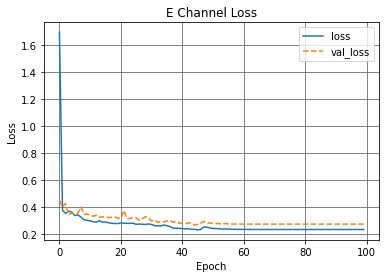

In [24]:
# Loss Plots #

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'], '--')
ax.legend(['loss', 'val_loss'], loc='upper right') 
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('E Channel Loss')
plt.rcParams['figure.figsize'] = (5,5)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.show()

In [44]:
# Uncertainty Quantification #
%run uq_epistemic.py

In [45]:
mc_num = 50
ep_e = uq_ec(train_e,model_e,bach_size,mc_num)

In [47]:
ep_e = np.reshape(ep_e,(2428,1))
print(ep_e.shape)

(2428, 1)


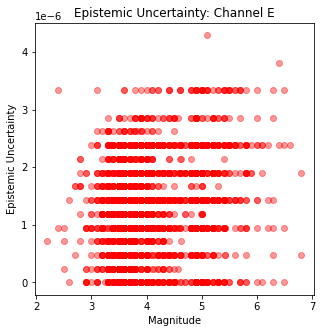

In [49]:
# Visualise

plt.figure()
plt.plot(ytrain_e, ep_e, 'ro', alpha=0.4)
plt.xlabel('Magnitude')
plt.ylabel('Epistemic Uncertainty')
plt.title('Epistemic Uncertainty: Channel E')
plt.show() 

In [51]:
# Evaluate

eva = model_e.evaluate(test_e, ytest_e)
print('test loss: ',eva)

predic_e = model_e.predict(test_e)

9/9 [==============================] - 0s 6ms/step - loss: 0.2337
test loss:  0.23365963995456696
9/9 [==============================] - 0s 5ms/step


Text(0.5, 1.0, 'Measured Vs. Predicted: Channel E')

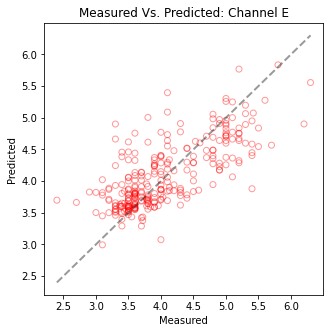

In [54]:
# Measured Vs. Predicted

fig, ax = plt.subplots()
ax.scatter(ytest_e, predic_e, alpha = 0.4, facecolors='none', edgecolors='r')
ax.plot([ytest_e.min(), ytest_e.max()], [ytest_e.min(), ytest_e.max()], 'k--', alpha=0.4, lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Measured Vs. Predicted: Channel E')

# Training channel N

In [55]:
# Training the second channel: N
epochs_number = 100
bach_size = 10
drop_rate = 0.2

#strategy = tf.distribute.MirroredStrategy()

#with strategy.scope():

inp = Input(shape=(3001,1), dtype='float32', name='input_layer') 
#inp = tf.cast(inp, tf.int32)
# Embed frequency data #
#freq_embed = F2V(750,3001)(inp)
#freq_embed = tf.cast(freq_embed, tf.float32)
#print(K.get_value(e[:50]))
#encoder = Bidirectional(LSTM(50, return_sequences=True, dropout=0.0, recurrent_dropout=0.0))(inp)
#print(tf.shape(e))
#e = tf.reshape(e,(1500,200))
e1, awts, attn_out = attention1()(inp)
#awts = awts.numpy()
#print(type(a))
#attn_out = tf.reshape(attn_out,(1500,200))
#e = tf.expand_dims(attn_out,axis=2)
print(tf.shape(attn_out))

#c1 = Conv1D(64,20,padding='same')(attn_out)
m1 = MaxPooling1D(30,padding='same')(attn_out)
#c2 = Conv1D(64,20,padding='same')(m1)
m2 = MaxPooling1D(10,padding='same')(m1)

e = Bidirectional(LSTM(70,return_sequences=False,dropout=0.0,recurrent_dropout=0.0))(m2)

d = Dense(1)(e)
o = Activation('linear', name='output_layer')(d)

model_n = Model(inputs=[inp], outputs=o)

model_n.compile(optimizer='Adam', loss='MSE')

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=np.sqrt(0.1),
                                patience= 4,
                               min_lr=0.5e-10
                              )
model_n.summary()

KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, 3001, 1], name='tf.compat.v1.shape_2/Shape:0', description="created by layer 'tf.compat.v1.shape_2'")
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 3001, 1)]         0         
                                                                 
 attention1_1 (attention1)   ((None, 3001, 1),         3002      
                              (None, 3001, 1),                   
                              (None, 3001, 1))                   
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 101, 1)           0         
 1D)                                                             
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 11, 1)            0    

In [56]:
start = time.perf_counter()
history1 = model_n.fit(train_n, ytrain_n, epochs=epochs_number, validation_split=0.1, batch_size=bach_size, callbacks = [lr_reducer])
elap = time.perf_counter() - start
print('%.3f' % elap)

# Get attention scores
#enc = model.layers[1]
attention_layer = model_n.layers[1]
#encout = enc(train_e[0:1,:])
e2, awts, _ = attention_layer(train_n[0:1,:])
#print(tf.reduce_max(awts),tf.reduce_min(awts))
awts = tf.reshape(e2,(3001,1))
train1 = tf.reshape(train_e[0:1],(3001,1))
#print(tf.shape(awts))
#v = yz[:1]
#v = tf.reshape(v,(3001,1))
#av = tf.concat((awts,train1),axis=1)
#print(tf.shape(av))
#merged = tf.stack((awts,train1),axis=1)
#print(tf.shape(merged))
#fig, ax = plt.subplots(figsize=(10,10))
#fig, ax = plt.subplots(ncols=2, gridspec_kw=dict(width_ratios=[5,0.5]))
#title = 'Attention Heatmap'
#plt.title(title,fontsize=15)
#plt.setp(ax.get_xticklabels(), visible=False)
#ttl = ax.title
#ax.axis('off')
#ttl.set_position([0.5,1.05])
#sns.heatmap(awts[:,:])#, annot=True, cbar=True)#, ax=axs[1])
#fig.colorbar(axs[1].collections[0], cax=axs[1])
#plt.show()

Epoch 1/100
219/219 [==============================] - 6s 9ms/step - loss: 0.9964 - val_loss: 0.3737 - lr: 0.0010
Epoch 2/100
219/219 [==============================] - 1s 6ms/step - loss: 0.3595 - val_loss: 0.3137 - lr: 0.0010
Epoch 3/100
219/219 [==============================] - 1s 6ms/step - loss: 0.3406 - val_loss: 0.4129 - lr: 0.0010
Epoch 4/100
219/219 [==============================] - 1s 6ms/step - loss: 0.3625 - val_loss: 0.3447 - lr: 0.0010
Epoch 5/100
219/219 [==============================] - 1s 6ms/step - loss: 0.3418 - val_loss: 0.3384 - lr: 0.0010
Epoch 6/100
219/219 [==============================] - 1s 6ms/step - loss: 0.3521 - val_loss: 0.3905 - lr: 0.0010
Epoch 7/100
219/219 [==============================] - 1s 6ms/step - loss: 0.3288 - val_loss: 0.3323 - lr: 3.1623e-04
Epoch 8/100
219/219 [==============================] - 1s 6ms/step - loss: 0.3234 - val_loss: 0.3151 - lr: 3.1623e-04
Epoch 9/100
219/219 [==============================] - 1s 6ms/step - loss: 0.316

219/219 [==============================] - 1s 6ms/step - loss: 0.2588 - val_loss: 0.2739 - lr: 3.1623e-09
Epoch 71/100
219/219 [==============================] - 1s 6ms/step - loss: 0.2588 - val_loss: 0.2739 - lr: 3.1623e-09
Epoch 72/100
219/219 [==============================] - 1s 6ms/step - loss: 0.2588 - val_loss: 0.2739 - lr: 1.0000e-09
Epoch 73/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2588 - val_loss: 0.2739 - lr: 1.0000e-09
Epoch 74/100
219/219 [==============================] - 1s 6ms/step - loss: 0.2588 - val_loss: 0.2739 - lr: 1.0000e-09
Epoch 75/100
219/219 [==============================] - 1s 6ms/step - loss: 0.2588 - val_loss: 0.2739 - lr: 1.0000e-09
Epoch 76/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2588 - val_loss: 0.2739 - lr: 3.1623e-10
Epoch 77/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2588 - val_loss: 0.2739 - lr: 3.1623e-10
Epoch 78/100
219/219 [==============================] - 1s 6m

In [ ]:
# Save model

model_n.save('saved_models/Model_N')

In [ ]:
# Loss Plots #

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history1.history['loss'])
ax.plot(history1.history['val_loss'], '--')
ax.legend(['loss', 'val_loss'], loc='upper right') 
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('N Channel Loss')
plt.rcParams['figure.figsize'] = (5,5)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.show()

In [57]:
# Uncertainty Quantification #

mc_num = 50
ep_n = uq_ec(train_n,model_n,bach_size,mc_num)
ep_n = np.reshape(ep_n,(2428,1))
print(ep_n.shape)

(2428, 1)


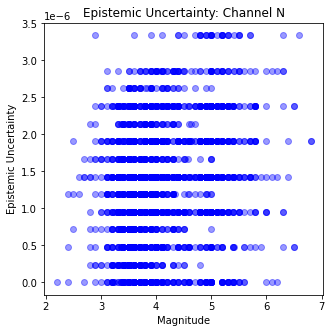

In [58]:
# Visualise

plt.figure()
plt.plot(ytrain_n, ep_n, 'bo', alpha=0.4)
plt.xlabel('Magnitude')
plt.ylabel('Epistemic Uncertainty')
plt.title('Epistemic Uncertainty: Channel N')
plt.show() 

In [60]:
# Evaluate

eva1 = model_n.evaluate(test_n, ytest_n)
print('test loss: ',eva1)

predic1 = model_n.predict(test_n)

9/9 [==============================] - 0s 5ms/step - loss: 0.2514
test loss:  0.25140395760536194
9/9 [==============================] - 0s 5ms/step


Text(0.5, 1.0, 'Measured Vs. Predicted: Channel N')

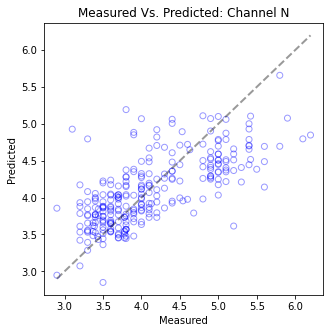

In [61]:
# Measured Vs. Predicted

fig, ax = plt.subplots()
ax.scatter(ytest_n, predic1, alpha = 0.4, facecolors='none', edgecolors='b')
ax.plot([ytest_n.min(), ytest_n.max()], [ytest_n.min(), ytest_n.max()], 'k--', alpha=0.4, lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Measured Vs. Predicted: Channel N')

# Training channel Z

In [62]:
# Training the third channel: Z
epochs_number = 100
bach_size = 10
drop_rate = 0.2

#strategy = tf.distribute.MirroredStrategy()

#with strategy.scope():

inp = Input(shape=(3001,1), dtype='float32', name='input_layer') 
#inp = tf.cast(inp, tf.int32)
# Embed frequency data #
#freq_embed = F2V(750,3001)(inp)
#freq_embed = tf.cast(freq_embed, tf.float32)
#print(K.get_value(e[:50]))
#encoder = Bidirectional(LSTM(50, return_sequences=True, dropout=0.0, recurrent_dropout=0.0))(inp)
#print(tf.shape(e))
#e = tf.reshape(e,(1500,200))
e1, awts, attn_out = attention1()(inp)
#awts = awts.numpy()
#print(type(a))
#attn_out = tf.reshape(attn_out,(1500,200))
#e = tf.expand_dims(attn_out,axis=2)
print(tf.shape(attn_out))

#c1 = Conv1D(64,20,padding='same')(attn_out)
m1 = MaxPooling1D(30,padding='same')(attn_out)
#c2 = Conv1D(64,20,padding='same')(m1)
m2 = MaxPooling1D(10,padding='same')(m1)

e = Bidirectional(LSTM(70,return_sequences=False,dropout=0.0,recurrent_dropout=0.0))(m2)

d = Dense(1)(e)
o = Activation('linear', name='output_layer')(d)

model_z = Model(inputs=[inp], outputs=o)

model_z.compile(optimizer='Adam', loss='MSE')

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=np.sqrt(0.1),
                                patience= 4,
                               min_lr=0.5e-10
                              )
model_z.summary()

KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, 3001, 1], name='tf.compat.v1.shape_3/Shape:0', description="created by layer 'tf.compat.v1.shape_3'")
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 3001, 1)]         0         
                                                                 
 attention1_2 (attention1)   ((None, 3001, 1),         3002      
                              (None, 3001, 1),                   
                              (None, 3001, 1))                   
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 101, 1)           0         
 1D)                                                             
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 11, 1)            0    

In [63]:
start = time.perf_counter()
history2 = model_z.fit(train_z, ytrain_z, epochs=epochs_number, validation_split=0.1, batch_size=bach_size, callbacks = [lr_reducer])
elap = time.perf_counter() - start
print('%.3f' % elap)

# Get attention scores
#enc = model.layers[1]
attention_layer = model_z.layers[1]
#encout = enc(train_e[0:1,:])
e2, awts, _ = attention_layer(train_z[0:1,:])
#print(tf.reduce_max(awts),tf.reduce_min(awts))
awts = tf.reshape(e2,(3001,1))
train1 = tf.reshape(train_e[0:1],(3001,1))
#print(tf.shape(awts))
#v = yz[:1]
#v = tf.reshape(v,(3001,1))
#av = tf.concat((awts,train1),axis=1)
#print(tf.shape(av))
#merged = tf.stack((awts,train1),axis=1)
#print(tf.shape(merged))
#fig, ax = plt.subplots(figsize=(10,10))
#fig, ax = plt.subplots(ncols=2, gridspec_kw=dict(width_ratios=[5,0.5]))
#title = 'Attention Heatmap'
#plt.title(title,fontsize=15)
#plt.setp(ax.get_xticklabels(), visible=False)
#ttl = ax.title
#ax.axis('off')
#ttl.set_position([0.5,1.05])
#sns.heatmap(awts[:,:])#, annot=True, cbar=True)#, ax=axs[1])
#fig.colorbar(axs[1].collections[0], cax=axs[1])
#plt.show()

Epoch 1/100
219/219 [==============================] - 4s 8ms/step - loss: 1.4291 - val_loss: 0.3765 - lr: 0.0010
Epoch 2/100
219/219 [==============================] - 1s 5ms/step - loss: 0.3347 - val_loss: 0.3012 - lr: 0.0010
Epoch 3/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2871 - val_loss: 0.3052 - lr: 0.0010
Epoch 4/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2747 - val_loss: 0.2843 - lr: 0.0010
Epoch 5/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2727 - val_loss: 0.2430 - lr: 0.0010
Epoch 6/100
219/219 [==============================] - 1s 5ms/step - loss: 0.3493 - val_loss: 0.3266 - lr: 0.0010
Epoch 7/100
219/219 [==============================] - 1s 5ms/step - loss: 0.3227 - val_loss: 0.3039 - lr: 0.0010
Epoch 8/100
219/219 [==============================] - 1s 5ms/step - loss: 0.3302 - val_loss: 0.3022 - lr: 0.0010
Epoch 9/100
219/219 [==============================] - 1s 5ms/step - loss: 0.3206 - val_

219/219 [==============================] - 1s 6ms/step - loss: 0.2645 - val_loss: 0.2573 - lr: 5.0000e-11
Epoch 71/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2645 - val_loss: 0.2573 - lr: 5.0000e-11
Epoch 72/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2645 - val_loss: 0.2573 - lr: 5.0000e-11
Epoch 73/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2645 - val_loss: 0.2573 - lr: 5.0000e-11
Epoch 74/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2645 - val_loss: 0.2573 - lr: 5.0000e-11
Epoch 75/100
219/219 [==============================] - 1s 6ms/step - loss: 0.2645 - val_loss: 0.2573 - lr: 5.0000e-11
Epoch 76/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2645 - val_loss: 0.2573 - lr: 5.0000e-11
Epoch 77/100
219/219 [==============================] - 1s 6ms/step - loss: 0.2645 - val_loss: 0.2573 - lr: 5.0000e-11
Epoch 78/100
219/219 [==============================] - 1s 5m

In [ ]:
# Save model

model_z.save('saved_models/Model_Z')

In [ ]:
# Loss Plots #

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history2.history['loss'])
ax.plot(history2.history['val_loss'], '--')
ax.legend(['loss', 'val_loss'], loc='upper right') 
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Z Channel Loss')
plt.rcParams['figure.figsize'] = (5,5)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.show()

In [64]:
# Uncertainty Quantification #

mc_num = 50
ep_z = uq_ec(train_z,model_z,bach_size,mc_num)
ep_z = np.reshape(ep_z,(2428,1))
print(ep_z.shape)

(2428, 1)


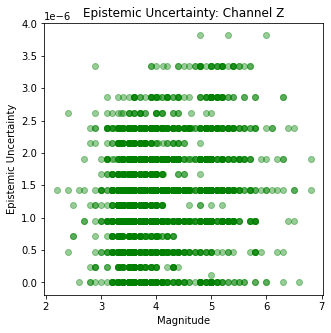

In [65]:
# Visualise

plt.figure()
plt.plot(ytrain_z, ep_z, 'go', alpha=0.4)
plt.xlabel('Magnitude')
plt.ylabel('Epistemic Uncertainty')
plt.title('Epistemic Uncertainty: Channel Z')
plt.show() 

In [66]:
# Evaluate

eva2 = model_z.evaluate(test_z, ytest_z)
print('test loss: ',eva1)

predic2 = model_z.predict(test_z)

9/9 [==============================] - 0s 6ms/step - loss: 0.2885
test loss:  0.25140395760536194
9/9 [==============================] - 0s 5ms/step


Text(0.5, 1.0, 'Measured Vs. Predicted: Channel Z')

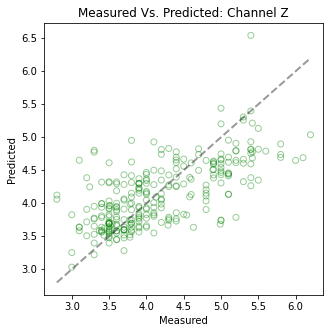

In [67]:
# Measured Vs. Predicted

fig, ax = plt.subplots()
ax.scatter(ytest_z, predic2, alpha = 0.4, facecolors='none', edgecolors='g')
ax.plot([ytest_z.min(), ytest_z.max()], [ytest_z.min(), ytest_z.max()], 'k--', alpha=0.4, lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Measured Vs. Predicted: Channel Z')